---
**License**

 NC_CCL_Colossus_density_profiles

 Mon Jun 01 09:20:00 2020\
 Copyright  2020\
 Sandro Dias Pinto Vitenti <vitenti@uel.br> \
 Mariana Penna-Lima        <pennalima@gmail.com>

---
---

 NC_CCL_Colossus_density_profiles\
 Copyright (C) 2020 Sandro Dias Pinto Vitenti <vitenti@uel.br>, Mariana Penna-Lima <pennalima@gmail.com>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [27]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from colossus.cosmology import cosmology
from colossus.halo import profile_nfw
from colossus.halo import profile_einasto
from colossus.halo import profile_hernquist
from colossus.halo import mass_so
from colossus.utils import constants

import pyccl as ccl

import sys
import numpy as np
import math
import matplotlib.pyplot as plt


In [28]:
# Colossus Cosmology
cosmo_col = cosmology.setCosmology('planck18');

Omega_c_col = cosmo_col.Om0 - cosmo_col.Ob0
Omega_b_col = cosmo_col.Ob0
h_col       = cosmo_col.H0 / 100.0
n_s_col     = cosmo_col.ns

print(Omega_c_col, Omega_b_col, h_col)

# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c_col, Omega_b=Omega_b_col, h=h_col, A_s=2.1e-9, n_s=n_s_col)

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

0.2621 0.049 0.6766


In [29]:
# NumCosmo Cosmology
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm{'massnu-length':<0>}")
#cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        cosmo_col.H0)
cosmo.param_set_by_name ("Omegak",    cosmo_col.Ok(0.0))
cosmo.param_set_by_name ("w",         cosmo_col.w0)
#cosmo.param_set_by_name ("w1",        cosmo_col.wa)
cosmo.param_set_by_name ("Omegab",    Omega_b_col)
cosmo.param_set_by_name ("Omegac",    Omega_c_col)
#cosmo.param_set_by_name ("massnu_0",  Planck13.m_nu.value[2])
#cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7 / 8 * (4 / 11)**(4 / 3))))
cosmo.param_set_by_name ("ENnu",      cosmo_col.Neff)
cosmo.param_set_by_name ("Tgamma0",   cosmo_col.Tcmb0)


In [30]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))

In [1]:
Delta = 200.0
Delta_ccl = 'vir'
Mvir  = 1.0e15 # M_sun
cvir  = 5.0
z     = 0.2
a     = 1.0 / (1.0 + z)

# CCL
MDEF               = 'matter'
mdef               = ccl.halos.MassDef (Delta_ccl, MDEF)
conc               = ccl.halos.ConcentrationConstant(cvir)
mdef.concentration = conc
ccl_nfw            = ccl.halos.HaloProfileNFW (conc,
                                               truncated = False, 
                                               projected_analytic = False, 
                                               cumul2d_analytic = False)
#ccl_nfw.update_precision_fftlog (n_per_decade = 1200)
ccl_ein            = ccl.halos.HaloProfileEinasto (conc,
                                                   truncated = False)
ccl_her            = ccl.halos.HaloProfileHernquist (conc,
                                                     truncated = False)


alpha = ccl_ein._get_alpha (cosmo_ccl, Mvir, a, mdef)
print (alpha)

# Colossus
col_nfw = profile_nfw.NFWProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir')
col_ein = profile_einasto.EinastoProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir', alpha = alpha)
col_her = profile_hernquist.HernquistProfile (M = (Mvir * cosmo.h ()), c = cvir, z = z, mdef = 'vir')

NameError: name 'ccl' is not defined

In [32]:
# NumCosmo
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True
log10Mvir = math.log10(Mvir)

nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta) 
nc_nfw.param_set_by_name ('cDelta', cvir) 
nc_nfw.param_set_by_name ('log10MDelta', log10Mvir) 

if improve_prec:
    nc_nfw.set_reltol (reltol) 
    nc_nfw.set_lnXi (lnXi)
    nc_nfw.set_lnXf (lnXf)

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta)
nc_ein.param_set_by_name ('cDelta', cvir) 
nc_ein.param_set_by_name ('log10MDelta', log10Mvir)
nc_ein.param_set_by_name ('alpha', alpha)

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

nc_her = Nc.HaloDensityProfileHernquist.new (Nc.HaloDensityProfileMassDef.VIRIAL, Delta)
nc_her.param_set_by_name ('cDelta', cvir) 
nc_her.param_set_by_name ('log10MDelta', log10Mvir) 

if improve_prec:
    nc_her.set_reltol (reltol) 
    nc_her.set_lnXi (lnXi)
    nc_her.set_lnXf (lnXf)

smd = Nc.WLSurfaceMassDensity.new (Nc.Distance.new (5.0))
smd.prepare (cosmo)

**Comparing NFW, Einasto and Hernquist the scale radius $r_s$ and $\rho_s$**

In [33]:
r     = 10**np.arange (-1, +4, 0.02) * 1.0e-3 # Mpc - physical
rho_m = cosmo_col.rho_m (z) * (cosmo.h2 () * 1.0e9) # matter density units: M_sun / Mpc^3

# CCL scale radius NFW
R_M = mdef.get_radius(cosmo_ccl, Mvir, a) / a 
c = conc.get_concentration(cosmo_ccl, Mvir, a, mdef_other=mdef)
ccl_rs = R_M / c
ccl_rhos = ccl_nfw._norm (Mvir, ccl_rs, c)

# Colossus 
(col_rhos, col_rs)  = col_nfw.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir')

# NumCosmo
(nc_rs, nc_rhos)    = nc_nfw.r_s_rho_s (cosmo, z)

cmp_double ("NFW:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_rhos)
cmp_double ("NFW:rs  ", "Colossus", "NumCosmo", col_rs / 1.0e3 / cosmo.h (), nc_rs)
cmp_double ("NFW:rhos", "CCL     ", "NumCosmo", ccl_rhos / a**3, nc_rhos)
cmp_double ("NFW:rs  ", "CCL     ", "NumCosmo", a * ccl_rs, nc_rs)

col_ein.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir', alpha = alpha)
(col_rhos, col_rs) = (col_ein.par['rhos'], col_ein.par['rs'])
(nc_rs, nc_rhos)   = nc_ein.r_s_rho_s (cosmo, z)

cmp_double ("EIN:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_rhos)
cmp_double ("EIN:rs  ", "Colossus", "NumCosmo", col_rs / (cosmo.h () * 1.0e3), nc_rs)

(col_rhos, col_rs) = col_her.fundamentalParameters (Mvir * cosmo.h (), cvir, z, 'vir')
(nc_rs, nc_rhos)   = nc_her.r_s_rho_s (cosmo, z)

cmp_double ("HER:rhos", "Colossus", "NumCosmo", col_rhos * (cosmo.h2 () * 1.0e9), nc_rhos)
cmp_double ("HER:rs  ", "Colossus", "NumCosmo", col_rs / (cosmo.h () * 1.0e3), nc_rs)


NFW:rhos: Colossus =   1.68206614880838e+15, NumCosmo =   1.68206616148168e+15, CMP:  7.53e-09
NFW:rs  : Colossus =      0.388079922045501, NumCosmo =      0.388079921070856, CMP:  2.51e-09
NFW:rhos: CCL      =   1.68206587754678e+15, NumCosmo =   1.68206616148168e+15, CMP:  1.69e-07
NFW:rs  : CCL      =      0.388079942906986, NumCosmo =      0.388079921070856, CMP:  5.63e-08
EIN:rhos: Colossus =        469377896488239, NumCosmo =        469377900024707, CMP:  7.53e-09
EIN:rs  : Colossus =      0.388079922045501, NumCosmo =      0.388079921070856, CMP:  2.51e-09
HER:rhos: Colossus =     4.254775350211e+15, NumCosmo =   4.25477538226804e+15, CMP:  7.53e-09
HER:rs  : Colossus =      0.388079922045501, NumCosmo =      0.388079921070856, CMP:  2.51e-09


**Comparing NFW, Einasto and Hernquist profiles $\rho(r) /\rho_m$**

[9.40692669e+16 9.36158458e+16 9.31571341e+16 9.26931074e+16
 9.22237429e+16 9.17490189e+16 9.12689149e+16 9.07834120e+16
 9.02924926e+16 8.97961405e+16 8.92943413e+16 8.87870820e+16
 8.82743513e+16 8.77561396e+16 8.72324391e+16 8.67032439e+16
 8.61685499e+16 8.56283551e+16 8.50826594e+16 8.45314647e+16
 8.39747754e+16 8.34125978e+16 8.28449407e+16 8.22718150e+16
 8.16932344e+16 8.11092147e+16 8.05197745e+16 7.99249350e+16
 7.93247200e+16 7.87191562e+16 7.81082730e+16 7.74921028e+16
 7.68706808e+16 7.62440455e+16 7.56122383e+16 7.49753039e+16
 7.43332900e+16 7.36862479e+16 7.30342321e+16 7.23773005e+16
 7.17155146e+16 7.10489394e+16 7.03776435e+16 6.97016992e+16
 6.90211825e+16 6.83361731e+16 6.76467548e+16 6.69530150e+16
 6.62550452e+16 6.55529407e+16 6.48468011e+16 6.41367297e+16
 6.34228344e+16 6.27052266e+16 6.19840225e+16 6.12593420e+16
 6.05313094e+16 5.98000533e+16 5.90657064e+16 5.83284058e+16
 5.75882927e+16 5.68455127e+16 5.61002155e+16 5.53525553e+16
 5.46026901e+16 5.385078

<Figure size 432x288 with 0 Axes>

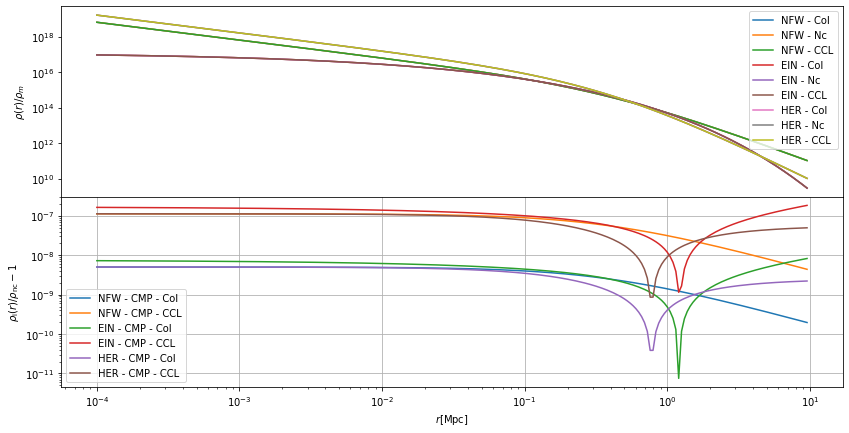

In [34]:
# Colossus density profiles
col_rho_nfw = col_nfw.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)
col_rho_ein = col_ein.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)
col_rho_her = col_her.density (r * cosmo.h () * 1.0e3) * (cosmo.h2 () * 1.0e9)

# NumCosmo density profiles
nc_rho_nfw  = np.array (nc_nfw.eval_density_array (cosmo, r, 1.0, 1.0, z))
nc_rho_ein  = np.array (nc_ein.eval_density_array (cosmo, r, 1.0, 1.0, z))
nc_rho_her  = np.array (nc_her.eval_density_array (cosmo, r, 1.0, 1.0, z))

# CCL density profiles
# CCL input: comoving distance 
ccl_rho_nfw = ccl_nfw.real (cosmo_ccl, r / a, Mvir, a, mdef) / a**3
ccl_rho_ein = ccl_ein.real (cosmo_ccl, r / a, Mvir, a, mdef) / a**3
ccl_rho_her = ccl_her.real (cosmo_ccl, r / a, Mvir, a, mdef) / a**3

print (nc_rho_ein, col_rho_ein, ccl_rho_ein)

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$r$[Mpc]')
axs[0].set_ylabel(r'$\rho (r) / \rho_m$')
axs[1].set_ylabel(r'$\rho_{\mathrm{i}} (r) / \rho_{\mathrm{nc}} - 1$')
axs[0].plot (r, col_rho_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, nc_rho_nfw,  '-', label = 'NFW - Nc')
axs[0].plot (r, ccl_rho_nfw, '-', label = 'NFW - CCL')
axs[0].plot (r, col_rho_ein, '-', label = 'EIN - Col')
axs[0].plot (r, nc_rho_ein,  '-', label = 'EIN - Nc')
axs[0].plot (r, ccl_rho_ein,  '-', label = 'EIN - CCL')
axs[0].plot (r, col_rho_her, '-', label = 'HER - Col')
axs[0].plot (r, nc_rho_her,  '-', label = 'HER - Nc')
axs[0].plot (r, ccl_rho_her,  '-', label = 'HER - CCL')
axs[1].plot (r, np.abs (col_rho_nfw / nc_rho_nfw  - 1.0), '-', label = "NFW - CMP - Col")
axs[1].plot (r, np.abs (ccl_rho_nfw / nc_rho_nfw - 1.0), '-', label = "NFW - CMP - CCL")
axs[1].plot (r, np.abs (col_rho_ein / nc_rho_ein - 1.0), '-', label = "EIN - CMP - Col")
axs[1].plot (r, np.abs (ccl_rho_ein / nc_rho_ein - 1.0), '-', label = "EIN - CMP - CCL")
axs[1].plot (r, np.abs (col_rho_her / nc_rho_her - 1.0), '-', label = "HER - CMP - Col")
axs[1].plot (r, np.abs (ccl_rho_her / nc_rho_her - 1.0), '-', label = "HER - CMP - CCL")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()

plt.show ()

**Comparing NFW, Einasto and Hernquist surface mass density $\Sigma (R)$**

<Figure size 432x288 with 0 Axes>

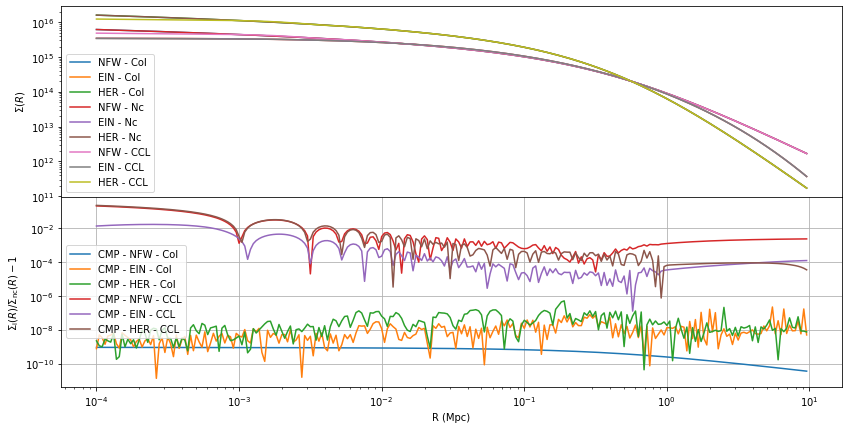

In [23]:
# Colossus
col_Sigma_nfw = col_nfw.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_ein = col_ein.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_Sigma_her = col_her.surfaceDensity (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1.0, 1.0, z)
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1.0, 1.0, z)
nc_Sigma_her  = smd.sigma_array (nc_her, cosmo, r, 1.0, 1.0, z)

# CCL
ccl_Sigma_nfw = ccl_nfw.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_ein = ccl_ein.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_Sigma_her = ccl_her.projected (cosmo_ccl, r / a, Mvir, a, mdef) / a**2

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Sigma (R)$')
axs[1].set_ylabel(r'$\Sigma_{\mathrm{i}} (R) / \Sigma_{\mathrm{nc}} (R) - 1$')
axs[0].plot (r, col_Sigma_nfw, '-', label = 'NFW - Col')
axs[0].plot (r, col_Sigma_ein, '-', label = 'EIN - Col')
axs[0].plot (r, col_Sigma_her, '-', label = 'HER - Col')
axs[0].plot (r, nc_Sigma_nfw,  '-', label = 'NFW - Nc')
axs[0].plot (r, nc_Sigma_ein,  '-', label = 'EIN - Nc')
axs[0].plot (r, nc_Sigma_her,  '-', label = 'HER - Nc')
axs[0].plot (r, ccl_Sigma_nfw, '-', label = 'NFW - CCL')
axs[0].plot (r, ccl_Sigma_ein, '-', label = 'EIN - CCL')
axs[0].plot (r, ccl_Sigma_her, '-', label = 'HER - CCL')
axs[1].plot (r, np.abs (col_Sigma_nfw / nc_Sigma_nfw - 1.0), '-', label = "CMP - NFW - Col")
axs[1].plot (r, np.abs (col_Sigma_ein / nc_Sigma_ein - 1.0), '-', label = "CMP - EIN - Col")
axs[1].plot (r, np.abs (col_Sigma_her / nc_Sigma_her - 1.0), '-', label = "CMP - HER - Col")
axs[1].plot (r, np.abs (ccl_Sigma_nfw / nc_Sigma_nfw - 1.0), '-', label = "CMP - NFW - CCL")
axs[1].plot (r, np.abs (ccl_Sigma_ein / nc_Sigma_ein - 1.0), '-', label = "CMP - EIN - CCL")
axs[1].plot (r, np.abs (ccl_Sigma_her / nc_Sigma_her - 1.0), '-', label = "CMP - HER - CCL")

axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()

**Comparing NFW, Einasto and Hernquist excess $\Delta\Sigma (R) = \overline\Sigma (<R) - \Sigma(R)$**

<Figure size 432x288 with 0 Axes>

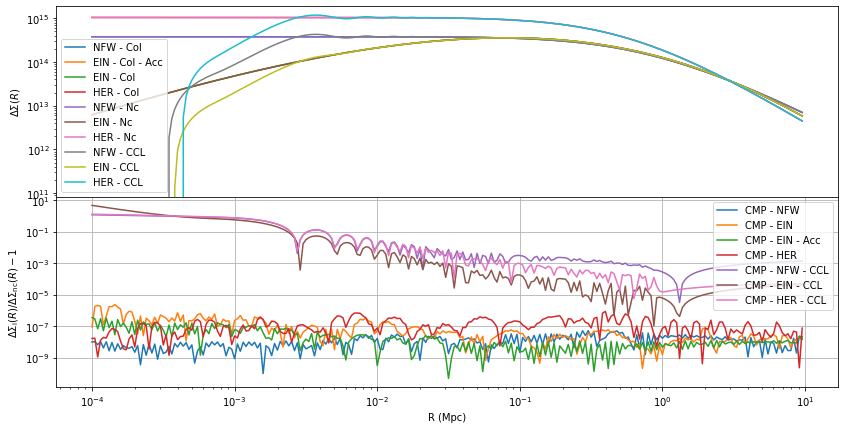

In [24]:
# Colossus
col_DeltaSigma_nfw  = col_nfw.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_ein  = col_ein.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)
col_DeltaSigma_Aein = col_ein.deltaSigma (r * cosmo.h () * 1.0e3, accuracy = 1.0e-9) * (cosmo.h () * 1.0e6)
col_DeltaSigma_her  = col_her.deltaSigma (r * cosmo.h () * 1.0e3) * (cosmo.h () * 1.0e6)

# NumCosmo
nc_DeltaSigma_nfw  = np.array (smd.sigma_excess_array (nc_nfw, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_ein  = np.array (smd.sigma_excess_array (nc_ein, cosmo, r, 1.0, 1.0, z))
nc_DeltaSigma_her  = np.array (smd.sigma_excess_array (nc_her, cosmo, r, 1.0, 1.0, z))

# CCL
ccl_BarSigma_nfw = ccl_nfw.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_nfw = ccl_BarSigma_nfw - ccl_Sigma_nfw
ccl_BarSigma_ein = ccl_ein.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_ein = ccl_BarSigma_ein - ccl_Sigma_ein
ccl_BarSigma_her = ccl_her.cumul2d (cosmo_ccl, r / a, Mvir, a, mdef) / a**2
ccl_DeltaSigma_her = ccl_BarSigma_her - ccl_Sigma_her

plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
axs[1].set_yscale ('log')
axs[1].set_xlabel('R (Mpc)')
axs[0].set_ylabel(r'$\Delta\Sigma(R)$')
axs[1].set_ylabel(r'$\Delta\Sigma_\mathrm{i}(R) / \Delta\Sigma_\mathrm{nc}(R) - 1$')
axs[0].plot (r, col_DeltaSigma_nfw,  '-', label = 'NFW - Col')
axs[0].plot (r, col_DeltaSigma_Aein, '-', label = 'EIN - Col - Acc')
axs[0].plot (r, col_DeltaSigma_ein,  '-', label = 'EIN - Col')
axs[0].plot (r, col_DeltaSigma_her,  '-', label = 'HER - Col')
axs[0].plot (r, nc_DeltaSigma_nfw,   '-', label = 'NFW - Nc')
axs[0].plot (r, nc_DeltaSigma_ein,   '-', label = 'EIN - Nc')
axs[0].plot (r, nc_DeltaSigma_her,   '-', label = 'HER - Nc')
axs[0].plot (r, ccl_DeltaSigma_nfw,  '-', label = 'NFW - CCL')
axs[0].plot (r, ccl_DeltaSigma_ein,  '-', label = 'EIN - CCL')
axs[0].plot (r, ccl_DeltaSigma_her,  '-', label = 'HER - CCL')
axs[1].plot (r, np.abs (col_DeltaSigma_nfw  / nc_DeltaSigma_nfw  - 1.0), '-', label = "CMP - NFW")
axs[1].plot (r, np.abs (col_DeltaSigma_ein  / nc_DeltaSigma_ein  - 1.0), '-', label = "CMP - EIN")
axs[1].plot (r, np.abs (col_DeltaSigma_Aein / nc_DeltaSigma_ein - 1.0), '-', label = "CMP - EIN - Acc")
axs[1].plot (r, np.abs (col_DeltaSigma_her  / nc_DeltaSigma_her  - 1.0), '-', label = "CMP - HER")
axs[1].plot (r, np.abs (ccl_DeltaSigma_nfw  / nc_DeltaSigma_nfw  - 1.0), '-', label = "CMP - NFW - CCL")
axs[1].plot (r, np.abs (ccl_DeltaSigma_ein  / nc_DeltaSigma_ein  - 1.0), '-', label = "CMP - EIN - CCL")
axs[1].plot (r, np.abs (ccl_DeltaSigma_her  / nc_DeltaSigma_her  - 1.0), '-', label = "CMP - HER - CCL")
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[1].grid()
plt.show ()